In [ ]:
# ! pip install datasets==1.18.3
# ! pip install transformers==4.18.0
! git clone https://github.com/mohsenfayyaz/GlobEnc

In [2]:
import torch
import numpy as np
import datasets
import pickle
import pathlib
import os
from importlib import reload

from tqdm.auto import tqdm
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from transformers.trainer_pt_utils import LengthGroupedSampler

from GlobEnc.src.modeling.modeling_bert import BertForSequenceClassification
from GlobEnc.src.modeling.modeling_electra import ElectraForSequenceClassification
from GlobEnc.src.attention_rollout import AttentionRollout

In [7]:
ROOT_DIR = "/home/modaresi/projects/globenc_analysis/outputs/globencs"
MODELS = {
#     "sst2-e0": "bert-large-uncased",
#     "sst2-e1": "/home/modaresi/projects/globenc_extension/outputs/output_sst2_bert-large-uncased_0001_SEED0042/checkpoint-2105",
#     "sst2-e2": "/home/modaresi/projects/globenc_extension/outputs/output_sst2_bert-large-uncased_0001_SEED0042/checkpoint-4210",
#     "sst2-e3": "/home/modaresi/projects/globenc_extension/outputs/output_sst2_bert-large-uncased_0001_SEED0042/checkpoint-6315",
#     "sst2-e4": "/home/modaresi/projects/globenc_extension/outputs/output_sst2_bert-large-uncased_0001_SEED0042/checkpoint-8420",
    "sst2-e5": "/home/modaresi/projects/globenc_analysis/outputs/models/output_sst2_bert-large-uncased_0001_SEED0042/checkpoint-10525",
}
# MODELS = {
#     "sst2-e0": "bert-base-uncased",
#     "sst2-e1": "/home/modaresi/projects/globenc_extension/outputs/output_sst2_bert-base-uncased_0001_SEED0042/checkpoint-2105",
#     "sst2-e2": "/home/modaresi/projects/globenc_extension/outputs/output_sst2_bert-base-uncased_0001_SEED0042/checkpoint-4210",
#     "sst2-e3": "/home/modaresi/projects/globenc_extension/outputs/output_sst2_bert-base-uncased_0001_SEED0042/checkpoint-6315",
#     "sst2-e4": "/home/modaresi/projects/globenc_extension/outputs/output_sst2_bert-base-uncased_0001_SEED0042/checkpoint-8420",
#     "sst2-e5": "/home/modaresi/projects/globenc_extension/outputs/output_sst2_bert-base-uncased_0001_SEED0042/checkpoint-10525",
# }
# MODELS = {
#     "mnli-e0": "bert-base-uncased",
#     "mnli-e1": "/home/modaresi/projects/globenc_extension/outputs/output_mnli_bert-base-uncased_0001_SEED0042/checkpoint-12272",
#     "mnli-e2": "/home/modaresi/projects/globenc_extension/outputs/output_mnli_bert-base-uncased_0001_SEED0042/checkpoint-24544",
#     "mnli-e3": "/home/modaresi/projects/globenc_extension/outputs/output_mnli_bert-base-uncased_0001_SEED0042/checkpoint-36816",
#     "mnli-e4": "/home/modaresi/projects/globenc_extension/outputs/output_mnli_bert-base-uncased_0001_SEED0042/checkpoint-49088",
#     "mnli-e5": "/home/modaresi/projects/globenc_analysis/outputs/models/output_mnli_bert-base-uncased_0001_SEED0042/checkpoint-61360",
# }
# MODELS = {
#     "cola-e0": "bert-base-uncased",
#     "cola-e1": "/home/modaresi/projects/globenc_extension/outputs/output_cola_bert-base-uncased_0001_SEED0042/checkpoint-268",
#     "cola-e2": "/home/modaresi/projects/globenc_extension/outputs/output_cola_bert-base-uncased_0001_SEED0042/checkpoint-536",
#     "cola-e3": "/home/modaresi/projects/globenc_extension/outputs/output_cola_bert-base-uncased_0001_SEED0042/checkpoint-804",
#     "cola-e4": "/home/modaresi/projects/globenc_extension/outputs/output_cola_bert-base-uncased_0001_SEED0042/checkpoint-1072",
#     "cola-e5": "/home/modaresi/projects/globenc_extension/outputs/output_cola_bert-base-uncased_0001_SEED0042/checkpoint-1340",
# }
# MODELS = {
#     "mrpc-e0": "bert-base-uncased",
#     "mrpc-e1": "/home/modaresi/projects/globenc_extension/outputs/output_mrpc_bert-base-uncased_0001_SEED0042/checkpoint-115",
#     "mrpc-e2": "/home/modaresi/projects/globenc_extension/outputs/output_mrpc_bert-base-uncased_0001_SEED0042/checkpoint-230",
#     "mrpc-e3": "/home/modaresi/projects/globenc_extension/outputs/output_mrpc_bert-base-uncased_0001_SEED0042/checkpoint-345",
#     "mrpc-e4": "/home/modaresi/projects/globenc_extension/outputs/output_mrpc_bert-base-uncased_0001_SEED0042/checkpoint-460",
#     "mrpc-e5": "/home/modaresi/projects/globenc_extension/outputs/output_mrpc_bert-base-uncased_0001_SEED0042/checkpoint-575",
# }
# MODELS = {
#     "qnli-e0": "bert-base-uncased",
#     "qnli-e1": "/home/modaresi/projects/globenc_extension/outputs/output_qnli_bert-base-uncased_0001_SEED0042/checkpoint-3274",
#     "qnli-e2": "/home/modaresi/projects/globenc_extension/outputs/output_qnli_bert-base-uncased_0001_SEED0042/checkpoint-6548",
#     "qnli-e3": "/home/modaresi/projects/globenc_extension/outputs/output_qnli_bert-base-uncased_0001_SEED0042/checkpoint-9822",
#     "qnli-e4": "/home/modaresi/projects/globenc_extension/outputs/output_qnli_bert-base-uncased_0001_SEED0042/checkpoint-13096",
#     "qnli-e5": "/home/modaresi/projects/globenc_extension/outputs/output_qnli_bert-base-uncased_0001_SEED0042/checkpoint-16370",
# }

# MULTI BERT
# MODELS = {
#     "multibert-qnli-s0": "google/multiberts-seed_0",
#     "multibert-qnli-s1": "google/multiberts-seed_1",
#     "multibert-qnli-s2": "google/multiberts-seed_2",
#     "multibert-qnli-s3": "google/multiberts-seed_3",
#     "multibert-qnli-s4": "google/multiberts-seed_4",
#     "multibert-qnli-s5": "google/multiberts-seed_5",
# }

# MODELS = {
#     "multibert-mrpc-s0": "google/multiberts-seed_0",
#     "multibert-mrpc-s1": "google/multiberts-seed_1",
#     "multibert-mrpc-s2": "google/multiberts-seed_2",
#     "multibert-mrpc-s3": "google/multiberts-seed_3",
#     "multibert-mrpc-s4": "google/multiberts-seed_4",
#     "multibert-mrpc-s5": "google/multiberts-seed_5",
# }

# MODELS = {
#     "multibert-cola-s0": "google/multiberts-seed_0",
#     "multibert-cola-s1": "google/multiberts-seed_1",
#     "multibert-cola-s2": "google/multiberts-seed_2",
#     "multibert-cola-s3": "google/multiberts-seed_3",
#     "multibert-cola-s4": "google/multiberts-seed_4",
#     "multibert-cola-s5": "google/multiberts-seed_5",
# }

# MODELS = {
#     "multibert-qnli-e0": "google/multiberts-seed_0-step_0k",
#     "multibert-qnli-e1": "google/multiberts-seed_0-step_400k",
#     "multibert-qnli-e2": "google/multiberts-seed_0-step_800k",
#     "multibert-qnli-e3": "google/multiberts-seed_0-step_1200k",
#     "multibert-qnli-e4": "google/multiberts-seed_0-step_1600k",
#     "multibert-qnli-e5": "google/multiberts-seed_0-step_2000k",
# }

# MODELS = {
#     "multibert-sst2-e0-20k": "google/multiberts-seed_0-step_0k",
#     "multibert-sst2-e1-20k": "google/multiberts-seed_0-step_20k",
#     "multibert-sst2-e2-20k": "google/multiberts-seed_0-step_40k",
#     "multibert-sst2-e3-20k": "google/multiberts-seed_0-step_60k",
#     "multibert-sst2-e4-20k": "google/multiberts-seed_0-step_80k",
#     "multibert-sst2-e5-20k": "google/multiberts-seed_0-step_100k",
# }

# MODELS = {
#     "multibert-sst2-e0-400k": "google/multiberts-seed_0-step_0k",
#     "multibert-sst2-e1-400k": "google/multiberts-seed_0-step_400k",
#     "multibert-sst2-e2-400k": "google/multiberts-seed_0-step_800k",
#     "multibert-sst2-e3-400k": "google/multiberts-seed_0-step_1200k",
#     "multibert-sst2-e4-400k": "google/multiberts-seed_0-step_1600k",
#     "multibert-sst2-e5-400k": "google/multiberts-seed_0-step_2000k",
# }

TASK = "sst2"

SET = "validation"  # train/validation/validation_matched
SAVE_CLS = True

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [4]:
GLUE_TASKS = ["cola", "mnli", "mnli-mm", "mrpc", "qnli", "qqp", "rte", "sst2", "stsb", "wnli"]

BATCH_SIZE = 24
MAX_LENGTH = 128

actual_task = "mnli" if TASK == "mnli-mm" else TASK
dataset = datasets.load_dataset("glue", actual_task)
metric = datasets.load_metric('glue', actual_task)
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mnli-mm": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}
SENTENCE1_KEY, SENTENCE2_KEY = task_to_keys[TASK]
dataset

Reusing dataset glue (/opt/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

In [5]:
def preprocess_function_wrapped(tokenizer):
    def preprocess_function(examples):
        # Tokenize the texts
        args = (
            (examples[SENTENCE1_KEY],) if SENTENCE2_KEY is None else (examples[SENTENCE1_KEY], examples[SENTENCE2_KEY])
        )
        result = tokenizer(*args, padding=False, max_length=MAX_LENGTH, truncation=True)
        return result
    return preprocess_function

def token_id_to_tokens_mapper(tokenizer, sample):
    length = len(sample["input_ids"])
    return tokenizer.convert_ids_to_tokens(sample["input_ids"])[:length], length

def save_pickle(obj, path):
    pathlib.Path(os.path.dirname(path)).mkdir(parents=True, exist_ok=True) 
    with open(path, 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Saved {path}")

In [8]:
for name, path in tqdm(MODELS.items(), desc="Models"):
    model = BertForSequenceClassification.from_pretrained(path)
    tokenizer = AutoTokenizer.from_pretrained(path, use_fast=True, max_length=128)

    sel_dataset = dataset[SET].map(preprocess_function_wrapped(tokenizer), batched=True, batch_size=1024)
    dataset_size = len(sel_dataset)
    steps = int(np.ceil(dataset_size / BATCH_SIZE))

    globencs = {"globenc": [], "tokens": [], "cls": []}
    lengths = []

    for i in tqdm(range(dataset_size), desc="Tokenize"):
        tokens, length = token_id_to_tokens_mapper(tokenizer, sel_dataset[i])
        globencs["tokens"].append(tokens)
        lengths.append(length)

    generator = torch.Generator()
    generator.manual_seed(int(torch.empty((), dtype=torch.int64).random_().item()))

    sampler = LengthGroupedSampler(
        BATCH_SIZE,
        lengths=lengths,
        model_input_name=tokenizer.model_input_names[0],
        generator=generator,
    )

    collator = DataCollatorWithPadding(
        tokenizer=tokenizer
    )

    sel_dataset = sel_dataset.add_column("length", lengths)
    sel_dataset.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "length", "idx"])

    dataloader = DataLoader(
                sel_dataset,
                batch_size=BATCH_SIZE,
                sampler=sampler,
                collate_fn=collator
    )

    model.to(DEVICE)

    it = iter(dataloader)

    idxes = []
    shuffled_globencs, shuffled_cls = [], []
    with torch.no_grad():
        for i in tqdm(range(steps), desc="GlobEnc"):
            batch = next(it)
            input_batch = {k: batch[k].to(DEVICE) for k in ["input_ids", "token_type_ids", "attention_mask"]}
            if SAVE_CLS:
                logits, hidden_states, norms = model(**input_batch, output_attentions=False, output_norms=False, 
                                                     return_dict=False, output_globenc=True, output_hidden_states=True)
            else:
                logits, norms = model(**input_batch, output_attentions=False, output_norms=False, 
                                                     return_dict=False, output_globenc=True, output_hidden_states=False)
            globenc = norms.squeeze().cpu().numpy()
            batch_lengths = batch["length"].numpy()
            idxes.extend(batch['idx'].tolist())
            shuffled_globencs.extend([globenc[j][:batch_lengths[j],:batch_lengths[j]] for j in range(len(globenc))])
            
            if SAVE_CLS:
                cls_repr = hidden_states[-1][:, 0, :].cpu().numpy()  # [13, batch, len, 768]
                shuffled_cls.extend(cls_repr)

    inverse_idxes = np.argsort(idxes)
    globencs["globenc"] = [shuffled_globencs[inverse_idxes[i]] for i in range(dataset_size)]
    if SAVE_CLS:
        globencs["cls"] = [shuffled_cls[inverse_idxes[i]] for i in range(dataset_size)]
#     save_pickle(globencs, f"{ROOT_DIR}/{name}_{SET}_{list(MODELS.values())[0].replace('/', '-')}.pickle")

Models:   0%|          | 0/1 [00:00<?, ?it/s]

Parameter 'function'=<function preprocess_function_wrapped.<locals>.preprocess_function at 0x7f252731f710> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

Tokenize:   0%|          | 0/872 [00:00<?, ?it/s]

GlobEnc:   0%|          | 0/37 [00:00<?, ?it/s]

{'sentence': 'hide new secretions from the parental units ', 'label': 0, 'idx': 0}
['[CLS]', 'hide', 'new', 'secret', '##ions', 'from', 'the', 'parental', 'units', '[SEP]']


<AxesSubplot:>

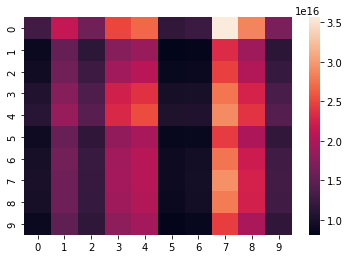

In [6]:
from seaborn import heatmap
print(dataset[SET][0])
print(globencs["tokens"][0])
heatmap(globencs["globenc"][0])

In [ ]:
! nvidia-smi

In [9]:
list(MODELS.values())[0].replace('/', '-')

'-home-modaresi-projects-globenc_analysis-outputs-models-output_mnli_bert-base-uncased_0001_SEED0042-checkpoint-61360'

In [9]:
save_pickle(globencs, f"{ROOT_DIR}/sst2-e5_validation_bert-base-uncased.pickle")

Saved /home/modaresi/projects/globenc_analysis/outputs/globencs/sst2-e5_validation_bert-base-uncased.pickle
